## Import libraries and file

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import re
import nltk
import textstat

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

from langdetect import detect
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import RegexpTokenizer
from transformers import pipeline
#from setfit import load_dataset, AbsaTrainer, AbsaModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec, LdaMulticore
from gensim.corpora.dictionary import Dictionary
#from readability import Readability
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Twitter Data

In [8]:
path = '../data/raw/twitter_dataset.csv'

In [9]:
tweet = pd.read_csv(path)

In [10]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [11]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   10000 non-null  int64 
 1   Username   10000 non-null  object
 2   Text       10000 non-null  object
 3   Retweets   10000 non-null  int64 
 4   Likes      10000 non-null  int64 
 5   Timestamp  10000 non-null  object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


## Data Exploration

In [12]:
tweet.shape

(10000, 6)

In [13]:
tweet.nunique()

Tweet_ID     10000
Username      9447
Text         10000
Retweets       101
Likes          101
Timestamp     9993
dtype: int64

In [14]:
# Check for Nan values
tweet.isna().sum()

Tweet_ID     0
Username     0
Text         0
Retweets     0
Likes        0
Timestamp    0
dtype: int64

In [15]:
# Explore random tweets to understand the kind of text
print(tweet.iloc[0,2])
print(tweet.iloc[10,2])

Party least receive say or single. Prevent prevent husband affect. May himself cup style evening protect. Effect another themselves stage perform.
Possible try tax share style television with. Successful much sell development economy effect.
Image simply article list event imagine want reach. Floor best west human American plant. Board scientist party suggest exactly.
Computer product one.


In [16]:
tweet.describe()

,Tweet_ID,Retweets,Likes
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,49.721200,49.929300
std,2886.89568,28.948856,28.877193
min,1.00000,0.000000,0.000000
25%,2500.75000,25.000000,25.000000
50%,5000.50000,49.000000,50.000000
75%,7500.25000,75.000000,75.000000
max,10000.00000,100.000000,100.000000


In [17]:
# Inspect the correlation between the engagement metrics

correlation = tweet['Retweets'].corr(tweet['Likes'])
print("Correlation between Retweets and Likes:", correlation)

Correlation between Retweets and Likes: 0.012797546201034817


Since there is no reliable argument to chose an engagement metric over an other, we chose to combine them

In [21]:
tweet['Total_engagement'] = tweet['Likes'] + tweet['Retweets']
tweet.head(3)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,27
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,64
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,76


## Preprocessing

In [22]:
# Change the Timestamp to the correct datetime format

tweet['Timestamp'] = pd.to_datetime(tweet['Timestamp'], format='%Y-%m-%d %H:%M:%S')

tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Tweet_ID          10000 non-null  int64         
 1   Username          10000 non-null  object        
 2   Text              10000 non-null  object        
 3   Retweets          10000 non-null  int64         
 4   Likes             10000 non-null  int64         
 5   Timestamp         10000 non-null  datetime64[ns]
 6   Total_engagement  10000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 547.0+ KB


In [23]:
languages = []

# Loop over the sentences in the list and detect their language
for sentence in tweet["Text"]:
    languages.append(detect(sentence))
    
# Assign the list to a new feature 
tweet['language'] = languages

tweet['language'].value_counts()

language
en    10000
Name: count, dtype: int64

### Data Cleaning

In [24]:
# Clean the document
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner',"tagger","parser")
stop_words = nltk.corpus.stopwords.words('english') # initialize the stop word list

# Define the list of stopwords
stop_words = set(stopwords.words('english'))

def normalize_document(tweet):
    # Lowercase and remove special characters/whitespaces
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet, re.I|re.A)
    tweet = tweet.lower().strip()

    # Remove multiple white spaces. Reduce these to singlw white spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Remove URLs and mentions
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"@\S+", "", tweet)

    # Remove next lines and replace with a space
    tweet = re.sub(r'\n', ' ', tweet)

    # Tokenization
    tokens = word_tokenize(tweet)

    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]

    # Remove stopwords
    filtered_tokens =[token for token in tokens if token not in stop_words]

    # Correct spelling errors using TextBlob
    corrected_tokens = [str(TextBlob(token).correct()) for token in filtered_tokens]

    # Lemmatization with spaCy
    # Convert tokens back to one single string for spaCy processing
    processed_text = ' '.join(corrected_tokens)
    doc = nlp(processed_text)
    lemmatized_tokens = [token.lemma_ for token in doc]

    return lemmatized_tokens


# Apply preprocessing
tweet['processed_text'] = tweet['Text'].apply(normalize_document)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [25]:
# Generate the cleaned tweets
norm_tweets = [normalize_document(r) for r in tweet["Text"]]

norm_tweets_list= [i for b in norm_tweets for i in b]

c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


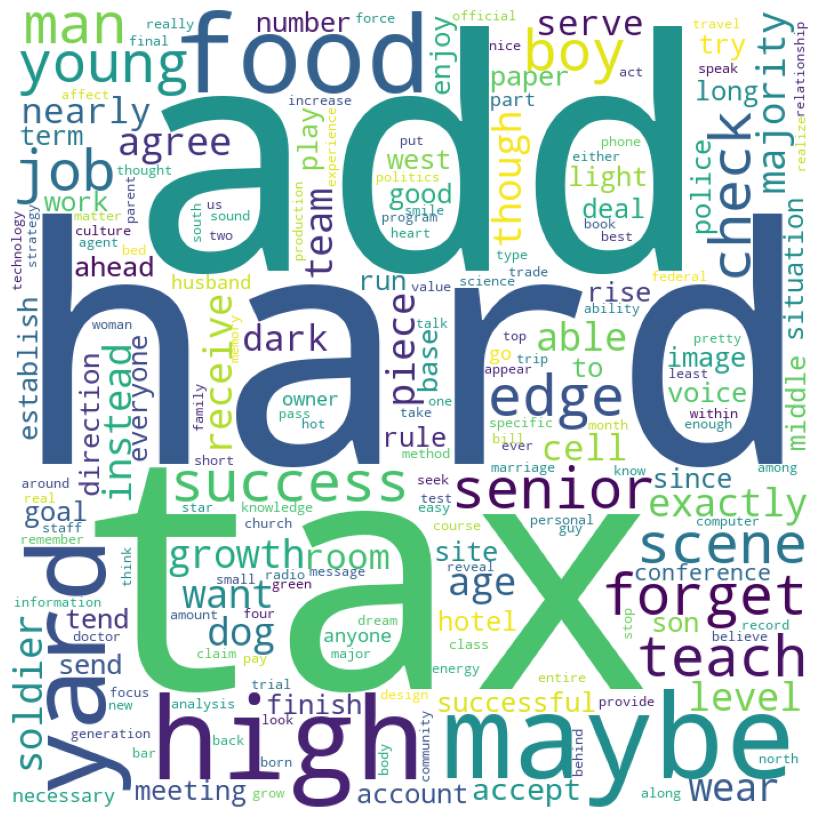

In [26]:
# Creating the word cloud from the frequency of occurence of words

frequency_cleaned = Counter(norm_tweets_list)

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                min_font_size = 10)

wordcloud.generate_from_frequencies(frequency_cleaned)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Feature Extraction

### Date

In [28]:


tweet['hour_of_day'] = tweet['Timestamp'].dt.hour
tweet['day_of_week'] = tweet['Timestamp'].dt.dayofweek
tweet['is_weekend'] = tweet['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

tweet['quarter'] = tweet['Timestamp'].dt.quarter
tweet['semester'] = (tweet['Timestamp'].dt.month - 1) // 6 + 1

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

tweet['part_of_day'] = tweet['hour_of_day'].apply(part_of_day)


In [29]:
tweet.head(3)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,day_of_week,is_weekend,quarter,semester,part_of_day
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,27,en,"[party, least, receive, say, single, prevent, ...",11,0,0,1,1,Morning
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,64,en,"[hotel, still, congress, may, member, staff, m...",22,0,0,1,1,Night
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,76,en,"[nice, debate, industry, year, film, generatio...",11,2,0,1,1,Morning


### User information

We aim to integrate features related to user past activity, including number of previous tweets and engagement generated 

In [30]:
# Tweeted in the past?

# Sort to check whether the user has tweeted in the past (before the current tweet)
tweet.sort_values(by=['Username', 'Timestamp'], inplace=True)

# Create a shifted version of the 'Username' column to compare with the current 'Username'
tweet['previous_username'] = tweet['Username'].shift(1)
tweet['tweeted_in_past'] = (tweet['Username'] == tweet['previous_username']).astype(int)



In [31]:
# Number of occurences per user

tweet['count'] = tweet.groupby('Username').cumcount() + 1  # cumcount starts at 0, so add 1


In [32]:
#  Cumulative Sum and Mean of Total Engagement

tweet['cumulative_total_engagement'] = tweet.groupby('Username')['Total_engagement'].cumsum()
tweet['sum_total_engagement'] = tweet['cumulative_total_engagement'] - tweet['Total_engagement']
tweet['mean_total_engagement'] = tweet.groupby('Username')['Total_engagement'].expanding().mean().reset_index(level=0, drop=True)

# Put 0 for first tweet of each user 

tweet.loc[tweet['count'] == 1, 'tweeted_in_past'] = 0
tweet.loc[tweet['count'] == 1, 'sum_total_engagement'] = 0
tweet.loc[tweet['count'] == 1, 'mean_total_engagement'] = 0

In [34]:
# Remove temp columns

tweet.drop(columns=['previous_username', 'cumulative_total_engagement'], inplace=True)
tweet.head(3)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,day_of_week,is_weekend,quarter,semester,part_of_day,tweeted_in_past,count,sum_total_engagement,mean_total_engagement
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,6,1,2,1,Morning,0,1,0,0.0
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,5,1,1,1,Morning,0,1,0,0.0
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,1,0,1,1,Morning,0,1,0,0.0


In [35]:
tweet.describe()

,Tweet_ID,Retweets,Likes,Timestamp,Total_engagement,hour_of_day,day_of_week,is_weekend,quarter,semester,tweeted_in_past,count,sum_total_engagement,mean_total_engagement
count,10000.00000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,49.721200,49.929300,2023-03-08 19:55:00.845099776,99.650500,11.472900,2.974500,0.277600,1.328200,1.0,0.055300,1.065000,6.489200,5.508467
min,1.00000,0.000000,0.000000,2023-01-01 00:01:15,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000
25%,2500.75000,25.000000,25.000000,2023-02-02 18:35:42.500000,70.000000,5.000000,1.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000
50%,5000.50000,49.000000,50.000000,2023-03-08 17:56:55.500000,99.000000,11.000000,3.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000
75%,7500.25000,75.000000,75.000000,2023-04-11 09:22:33.750000128,130.000000,17.000000,5.000000,1.000000,2.000000,1.0,0.000000,1.000000,0.000000,0.000000
max,10000.00000,100.000000,100.000000,2023-05-15 12:32:09,200.000000,23.000000,6.000000,1.000000,2.000000,1.0,1.000000,6.000000,629.000000,177.000000
std,2886.89568,28.948856,28.877193,NaN,41.150031,6.917648,2.002411,0.447837,0.469582,0.0,0.228576,0.292547,31.216408,23.726891


### Sentiment Analysis

Explore Sentiment analysis using the VADER(Valence Aware Dictionary and sEntiment Reasoner) lexicon; which is a popular rules based sentiment analysis lexicon for social media. It incorporates Slangs, emojis and other formats unique to social media. It is made up of
1. neg (Negative sentiment):
ii. pos (Positive sentiment)
iii. neu (Neutral sentiment)
iv. compound (Overall sentiment of the text with range -1 to 1)

This step seeks to analyse the overall sentiment of the tweet

In [38]:
nltk.download('vader_lexicon')

def add_sentiment_scores(tweet):
    sid = SentimentIntensityAnalyzer()
    
    # Apply the polarity_scores method to each text
    sentiments = tweet['Text'].apply(sid.polarity_scores)
    sentiments_df = pd.DataFrame(sentiments.tolist())
    sentiments_df.columns = ['neg_tweet_sentiment', 'neu_tweet_sentiment', 'pos_tweet_sentiment', 'tweet_sentiment_compound']
    tweet = tweet.join(sentiments_df)
    
    return tweet


# Add sentiment scores to the DataFrame
tweet = add_sentiment_scores(tweet)

tweet['highly_positive'] = tweet['tweet_sentiment_compound'].apply(lambda x: 1 if x > 0.5 else 0)
tweet['highly_negative'] = tweet['tweet_sentiment_compound'].apply(lambda x: 1 if x < -0.5 else 0)


# Display the first few rows of the DataFrame to check the new sentiment columns
tweet.head(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,tweeted_in_past,count,sum_total_engagement,mean_total_engagement,neg_tweet_sentiment,neu_tweet_sentiment,pos_tweet_sentiment,tweet_sentiment_compound,highly_positive,highly_negative
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,0,1,0,0.0,0.142,0.694,0.163,0.1531,0,0
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,0,1,0,0.0,0.000,0.872,0.128,0.4215,0,0
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,0,1,0,0.0,0.046,0.741,0.214,0.7096,1,0
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,0,1,0,0.0,0.067,0.604,0.329,0.8463,1,0
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,0,1,0,0.0,0.038,0.587,0.375,0.9380,1,0


This step of sentiment analysis is to calculate the sentiment scores per aspect of the tweet using the Aspect-Based Sentiment Analysis (ABSA). We attempted to integrate the SetFitABSA model, developed by Hugging Face and Intel Labs, to perform Aspect-Based Sentiment Analysis (ABSA) on tweets, however, there were several unresolved issues around importing SetFit. Transformers were also explored, using pipelines and torch, but we were met with limited resources to run these. Therefore, Textblob (which is the least preferred option was utilised) was used to achieve the same results which allows the extraction of key aspects of the different tweets and analyze the sentiments associated with these aspects.

In [40]:
# from setfit import AbsaModel
# !spacy download en_core_web_lg

# model = AbsaModel.from_pretrained("BAAI/bge-small-en-v1.5")

     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     -------------------------------------- 0.0/587.7 MB 325.1 kB/s eta 0:30:08
     -------------------------------------- 0.0/587.7 MB 325.1 kB/s eta 0:30:08
     -------------------------------------- 0.1/587.7 MB 328.2 kB/s eta 0:29:51
     -------------------------------------- 0.1/587.7 MB 280.5 kB/s eta 0:34:55
     -------------------------------------- 0.1/587.7 MB 423.5 kB/s eta 0:23:08
     -------------------------------------- 0.2/587.7 MB 588.9 kB/s eta 0:16:38
     -------------------------------------- 0.2/587.7 MB 655.6 kB/s eta 0:14:57
     -------------------------------------- 0.3/587.7 MB 605.3 kB/s eta 0:16:11
     -------------------------------------- 0.3/587.7 MB 807.1 kB/s eta 0:12:08
     -------------------------------------- 0.5/587.7 MB 907.9 kB/s eta 0:10:47
     -------------------------------------- 0.5/587.7 

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [42]:
# def extract_aspects(text):
#     doc = nlp(text)
#     # Extract noun phrases; this tends to work better for aspects than individual nouns
#     aspects = [chunk.text for chunk in doc.noun_chunks]
#     return aspects

# def analyze_tweet(tweet):
#     aspects = extract_aspects(tweet)
#     # Predict sentiment for each aspect
#     predictions = model.predict(aspects)
#     return dict(zip(aspects, predictions))

# # Apply the function to each tweet in your DataFrame
# tweet['ABSA'] = tweet['processed_text'].apply(analyze_tweet)


ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'list'>

In [43]:
from textblob import TextBlob

# Load English tokenizer, tagger, parser, NER, and word vectors from spaCy
nlp = spacy.load('en_core_web_sm')

def extract_aspects(tokens):
    """ Extracts noun phrases from a list of tokens using spaCy. """
    text = ' '.join(tokens)  # Join tokens into a single string
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

def analyze_aspect_sentiments(text, aspects):
    """ Analyzes sentiment for each aspect using TextBlob. """
    aspect_sentiments = {}
    for aspect in aspects:
        blob = TextBlob(aspect)
        sentiment = blob.sentiment
        if sentiment.polarity > 0:
            sentiment_label = 'Positive'
        elif sentiment.polarity < 0:
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'
        aspect_sentiments[aspect] = sentiment_label
    return aspect_sentiments


# Apply to tweet
tweet['Aspects'] = tweet['processed_text'].apply(extract_aspects)
tweet['AspectSentiments'] = tweet.apply(lambda row: analyze_aspect_sentiments(row['processed_text'], row['Aspects']), axis=1)
tweet['positive_aspect_count'] = tweet['AspectSentiments'].apply(lambda x: sum(1 for sentiment in x.values() if sentiment == 'Positive'))


Readability Scores

1a. Add Readabilty score to each Tweet to show how readable (or understandable) each tweet is. This shows the complexity of the tweets. The summary of scores include:
i. Flesch Reading Ease: Score Range: 0-100 (standard = 60 - 70. Lower scores are more difficult).
b. SMOG Index: Score Range: Typically 3-12 (corresponds to US grading system)
c. Flesch-Kincaid Grade Level: Similar to SMOG. 

In [44]:
# Function to add readability scores to the DataFrame
def add_readability_scores(tweet):
    tweet['flesch_reading_ease'] = tweet['Text'].apply(textstat.flesch_reading_ease)
    tweet['smog_index'] = tweet['Text'].apply(textstat.smog_index)
    tweet['flesch_kincaid_grade'] = tweet['Text'].apply(textstat.flesch_kincaid_grade)
    return tweet

# Adding readability scores
tweet = add_readability_scores(tweet)
tweet.head(5)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,pos_tweet_sentiment,tweet_sentiment_compound,highly_positive,highly_negative,Aspects,AspectSentiments,positive_aspect_count,flesch_reading_ease,smog_index,flesch_kincaid_grade
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,0.163,0.1531,0,0,"[society ability, adult, risk, anything]","{'society ability': 'Neutral', 'adult': 'Posit...",1,56.93,8.3,6.8
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,0.128,0.4215,0,0,"[opportunity, court, table, drug billion groun...","{'opportunity': 'Neutral', 'court': 'Neutral',...",1,57.23,8.3,6.7
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,0.214,0.7096,1,0,"[anyone level, gun imagine, entire century cou...","{'anyone level': 'Neutral', 'gun imagine': 'Ne...",1,66.10,7.4,5.4
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,0.329,0.8463,1,0,"[staff, skin glass couple major hand generatio...","{'staff': 'Neutral', 'skin glass couple major ...",1,74.56,7.6,4.2
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,0.375,0.9380,1,0,"[door, member fight garden, south ball truth e...","{'door': 'Neutral', 'member fight garden': 'Ne...",0,57.13,8.2,6.7


In [45]:
import pandas as pd
import re

def extract_text_features(tweet):
    # Assuming 'data' is a DataFrame with a column named 'text' for the tweets
    tweet['tweet_length'] = tweet['Text'].apply(len)
    tweet['word_count'] = tweet['Text'].apply(lambda x: len(x.split()))
    tweet['hashtag_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"#(\w+)", x)))
    tweet['mention_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"@(\w+)", x)))
    tweet['url_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", x)))
    return tweet

tweet = extract_text_features(tweet)
tweet.head(5)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,AspectSentiments,positive_aspect_count,flesch_reading_ease,smog_index,flesch_kincaid_grade,tweet_length,word_count,hashtag_count,mention_count,url_count
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,"{'society ability': 'Neutral', 'adult': 'Posit...",1,56.93,8.3,6.8,242,36,0,0,0
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,"{'opportunity': 'Neutral', 'court': 'Neutral',...",1,57.23,8.3,6.7,236,34,0,0,0
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,"{'anyone level': 'Neutral', 'gun imagine': 'Ne...",1,66.10,7.4,5.4,247,37,0,0,0
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,"{'staff': 'Neutral', 'skin glass couple major ...",1,74.56,7.6,4.2,257,42,0,0,0
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,"{'door': 'Neutral', 'member fight garden': 'Ne...",0,57.13,8.2,6.7,199,29,0,0,0


Named Entity Recognition (NER)

In [46]:
nlp = spacy.load("en_core_web_sm") 

# Function to extract named entities
def extract_entities(token_list):
    text = ' '.join(token_list)
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

# Assuming 'tweet' is your DataFrame and 'processed_text' contains lists of tokens
tweet['entities'] = tweet['processed_text'].apply(extract_entities)


In [47]:
 # Count the number of entities per tweet


# Function to extract and count named entities
def count_entities(token_list):
    # Join the list of tokens into a single string
    text = ' '.join(token_list)
    doc = nlp(text)
    # Return the count of named entities
    return len(doc.ents)

# Assuming 'tweet' is your DataFrame and 'processed_text' contains lists of tokens
tweet['entity_count'] = tweet['processed_text'].apply(count_entities)


In [48]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,flesch_reading_ease,smog_index,flesch_kincaid_grade,tweet_length,word_count,hashtag_count,mention_count,url_count,entities,entity_count
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,56.93,8.3,6.8,242,36,0,0,0,[],0
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,57.23,8.3,6.7,236,34,0,0,0,"[four, billion]",2
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,66.10,7.4,5.4,247,37,0,0,0,[],0
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,74.56,7.6,4.2,257,42,0,0,0,[year],1
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,57.13,8.2,6.7,199,29,0,0,0,[],0


Topic Modelling using LDA

In [49]:
# Step 1: Import necessary libraries
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pandas as pd
import nltk
nltk.download('punkt')

# Step 4: Create a dictionary and corpus needed for Topic Modeling
dictionary = Dictionary(tweet['processed_text'])
corpus = [dictionary.doc2bow(text) for text in tweet['processed_text']]

# Step 5: Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 6: Extract topics for each tweet
def get_lda_topics(bow):
    return lda_model.get_document_topics(bow)

tweet['lda_topics'] = [get_lda_topics(bow) for bow in corpus]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# Function to determine the dominant topic from a list of topics
def dominant_topic(lda_topics):
    if lda_topics:
        # Sort topics by the highest probability and return the topic with the highest probability
        return sorted(lda_topics, key=lambda x: -x[1])[0][0]
    return None

tweet['dominant_topic'] = tweet['lda_topics'].apply(dominant_topic)


In [51]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,flesch_kincaid_grade,tweet_length,word_count,hashtag_count,mention_count,url_count,entities,entity_count,lda_topics,dominant_topic
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,6.8,242,36,0,0,0,[],0,"[(0, 0.26505855), (3, 0.14743942), (4, 0.58076...",4
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,6.7,236,34,0,0,0,"[four, billion]",2,"[(2, 0.37667722), (3, 0.6136929)]",3
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,5.4,247,37,0,0,0,[],0,"[(1, 0.35898376), (3, 0.6046862), (4, 0.030118...",3
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,4.2,257,42,0,0,0,[year],1,"[(0, 0.7011247), (1, 0.14539924), (4, 0.147905...",0
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,6.7,199,29,0,0,0,[],0,"[(0, 0.09171996), (1, 0.34009737), (2, 0.41089...",2


Word Embeddings
 

The choice for word-embeddings is to use the pre-trained 'glove-twitter-25' which is intended to optimise the available resources. 

In [52]:
import gensim.downloader as api
from gensim.models import KeyedVectors

glove_twitter = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [53]:
def tweet_embedding(tokens, model):
    # Get vectors for each token in the tweet if the token is in the model
    vectors = [model[word] for word in tokens if word in model]
    
    if vectors:
        # Return the mean of the vectors
        return np.mean(vectors, axis=0)
    else:
        # Return a zero vector if none of the tokens are in the vocabulary
        return np.zeros(model.vector_size)


tweet['embedding'] = tweet['processed_text'].apply(lambda x: tweet_embedding(x, glove_twitter))

In [54]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Total_engagement,language,processed_text,hour_of_day,...,tweet_length,word_count,hashtag_count,mention_count,url_count,entities,entity_count,lda_topics,dominant_topic,embedding
1503,1504,aaguirre,Including clearly always society ability hit a...,97,80,2023-05-14 06:24:47,177,en,"[including, clearly, always, society, ability,...",6,...,242,36,0,0,0,[],0,"[(0, 0.26505855), (3, 0.14743942), (4, 0.58076...",4,"[0.03726406, 0.20415674, -0.49917045, -0.11140..."
7404,7405,aalexander,Opportunity imagine behind court describe. Bec...,83,76,2023-03-04 09:49:32,159,en,"[opportunity, imagine, behind, court, describe...",9,...,236,34,0,0,0,"[four, billion]",2,"[(2, 0.37667722), (3, 0.6136929)]",3,"[0.06235542, 0.34206426, -0.43488058, -0.03542..."
2341,2342,aaron00,Clearly rate anyone level. Take gun imagine to...,67,38,2023-02-28 08:53:28,105,en,"[clearly, rate, anyone, level, take, gun, imag...",8,...,247,37,0,0,0,[],0,"[(1, 0.35898376), (3, 0.6046862), (4, 0.030118...",3,"[0.06305241, 0.25115615, -0.041151367, -0.1705..."
557,558,aaron01,Just staff throughout skin glass couple major ...,1,24,2023-03-02 22:13:07,25,en,"[staff, throughout, skin, glass, couple, major...",22,...,257,42,0,0,0,[year],1,"[(0, 0.7011247), (1, 0.14539924), (4, 0.147905...",0,"[-0.08238488, 0.30781057, -0.25567922, -0.1117..."
8324,8325,aaron20,Door wrong throughout. Member fight garden con...,47,73,2023-01-19 12:38:03,120,en,"[door, wrong, throughout, member, fight, garde...",12,...,199,29,0,0,0,[],0,"[(0, 0.09171996), (1, 0.34009737), (2, 0.41089...",2,"[-0.15850256, 0.18360111, -0.09739049, -0.2281..."


In [55]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1503 to 8648
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tweet_ID                  10000 non-null  int64         
 1   Username                  10000 non-null  object        
 2   Text                      10000 non-null  object        
 3   Retweets                  10000 non-null  int64         
 4   Likes                     10000 non-null  int64         
 5   Timestamp                 10000 non-null  datetime64[ns]
 6   Total_engagement          10000 non-null  int64         
 7   language                  10000 non-null  object        
 8   processed_text            10000 non-null  object        
 9   hour_of_day               10000 non-null  int32         
 10  day_of_week               10000 non-null  int32         
 11  is_weekend                10000 non-null  int64         
 12  quarter              

Exploratory Data Analysis

c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


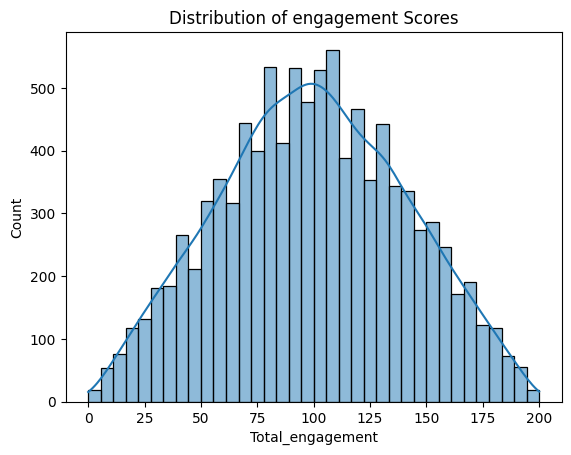

c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mperan\Documents\GitHub\NLP-twitter-engagement\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


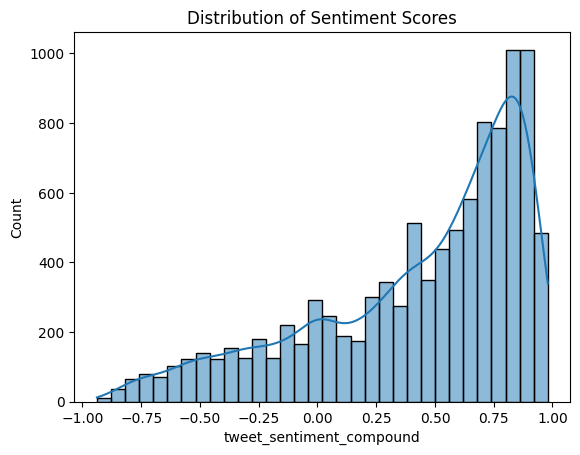

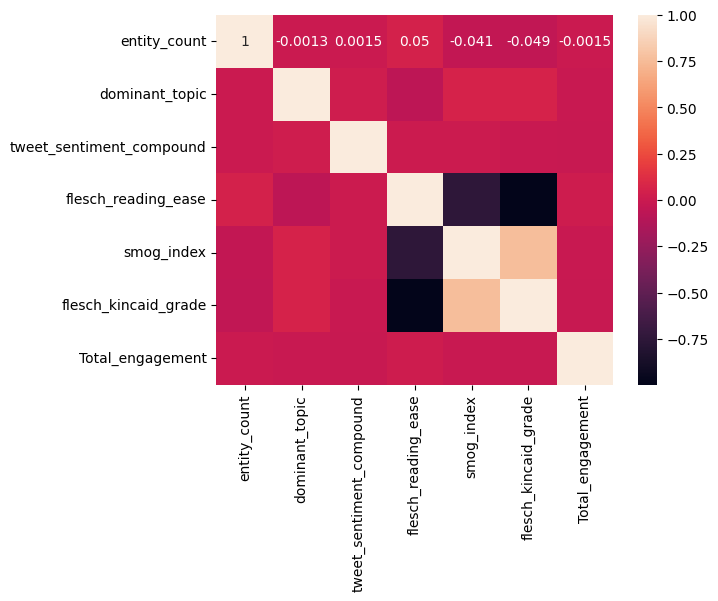

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distribution of engagement
sns.histplot(tweet['Total_engagement'], kde=True)
plt.title('Distribution of engagement Scores')
plt.show()

# Plotting distribution of sentiment
sns.histplot(tweet['tweet_sentiment_compound'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.show()

# Correlation heatmap
correlation = tweet[['entity_count', 'dominant_topic', 'tweet_sentiment_compound', 'flesch_reading_ease','smog_index', 'flesch_kincaid_grade', 'Total_engagement']].corr()  # Define 'engagement' correctly
sns.heatmap(correlation, annot=True)
plt.show()


Dimensionality Reduction

Model Building

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Assume each list of entities is joined into a single string separated by a space
# tweet['entities_str'] = tweet['entities'].apply(lambda x: ' '.join(x))

# # Initialize TF-IDF Vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Choose a suitable number of features
# tfidf_matrix = tfidf_vectorizer.fit_transform(tweet['entities_str'])

# # Convert to DataFrame and concatenate with original DataFrame
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
# tweet = pd.concat([tweet, tfidf_df], axis=1)


In [62]:
# List features
tweet['num_lda_topics'] = tweet['lda_topics'].apply(lambda x: len(x))
tweet['mean_lda_topic_prob'] = tweet['lda_topics'].apply(lambda x: np.mean([prob for _, prob in x]))

# Embedding features
embeddings_df = tweet['embedding'].apply(pd.Series)
embeddings_df.columns = ['embedding_' + str(i) for i in range(embeddings_df.shape[1])]
tweet = pd.concat([tweet, embeddings_df], axis=1)

In [66]:
import numpy as np

# Set the dependent variable (target)
dv_var = 'Total_engagement'

# Columns to exclude
var_to_exclude = ['Tweet_ID', 'Retweets', 'Likes', dv_var]

# Select features that are numerical but not in the exclusion list
features_list = tweet.select_dtypes(include=[np.number]).drop(columns=var_to_exclude).columns.tolist()

print("List of Features:", features_list)


List of Features: ['hour_of_day', 'day_of_week', 'is_weekend', 'quarter', 'semester', 'tweeted_in_past', 'count', 'sum_total_engagement', 'mean_total_engagement', 'neg_tweet_sentiment', 'neu_tweet_sentiment', 'pos_tweet_sentiment', 'tweet_sentiment_compound', 'highly_positive', 'highly_negative', 'positive_aspect_count', 'flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'tweet_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count', 'entity_count', 'dominant_topic', 'num_lda_topics', 'mean_lda_topic_prob', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24']


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define your independent variables (features) and the dependent variable (target)
X = tweet[features_list]
y = tweet[dv_var]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train models
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression()
}

# Dictionary to hold model scores for comparison
model_scores = {}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    model_scores[model_name] = mse
    print(f'{model_name} - Mean Squared Error: {mse}')

# Identify the best model
best_model_name = min(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f'Best Model: {best_model_name} with MSE: {model_scores[best_model_name]}')

# Final evaluation on test set using the best model
final_predictions = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print(f'Final Evaluation - Mean Squared Error: {final_mse}')


RandomForestRegressor - Mean Squared Error: 1621.29299205
GradientBoostingRegressor - Mean Squared Error: 1608.0409251382755
LinearRegression - Mean Squared Error: 1568.0219383901724
Best Model: LinearRegression with MSE: 1568.0219383901724
Final Evaluation - Mean Squared Error: 1568.0219383901724


In [70]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize more complex models
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(n_estimators=200, random_state=42)
}

# Dictionary to hold model scores for comparison
model_scores = {}

# Train and evaluate models
for model_name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores  # Convert to positive MSE scores
    rmse_scores = np.sqrt(mse_scores)  # Convert to RMSE scores

    # Fit the model on the entire training data
    model.fit(X_train, y_train)
    
    # Make predictions on test data
    predictions = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store metrics
    model_scores[model_name] = {
        'Mean Cross-Val MSE': np.mean(mse_scores),
        'Std Cross-Val RMSE': np.std(rmse_scores),
        'Test MSE': mse,
        'Test RMSE': rmse,
        'Test MAE': mae,
        'Test R2': r2
    }

    # Print the metrics
    print(f"{model_name} Performance:")
    print(f"Mean Cross-Val MSE: {np.mean(mse_scores):.4f} (±{np.std(mse_scores):.4f})")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")
    print("-" * 30)

# Identify the best model based on Test RMSE
best_model_name = min(model_scores, key=lambda x: model_scores[x]['Test RMSE'])
best_model_metrics = model_scores[best_model_name]
print(f'Best Model: {best_model_name}')
print(f"Test MSE: {best_model_metrics['Test MSE']:.4f}")
print(f"Test RMSE: {best_model_metrics['Test RMSE']:.4f}")
print(f"Test MAE: {best_model_metrics['Test MAE']:.4f}")
print(f"Test R2: {best_model_metrics['Test R2']:.4f}")


RandomForestRegressor Performance:
Mean Cross-Val MSE: 1664.5119 (±33.8592)
Test MSE: 1617.7435
Test RMSE: 40.2212
Test MAE: 32.5432
Test R2: 0.0126
------------------------------
GradientBoostingRegressor Performance:
Mean Cross-Val MSE: 1681.7230 (±41.9875)
Test MSE: 1626.4454
Test RMSE: 40.3292
Test MAE: 32.7499
Test R2: 0.0073
------------------------------
LinearRegression Performance:
Mean Cross-Val MSE: 1634.8168 (±31.8543)
Test MSE: 1568.0219
Test RMSE: 39.5983
Test MAE: 31.8528
Test R2: 0.0429
------------------------------
XGBRegressor Performance:
Mean Cross-Val MSE: 1968.8257 (±61.0722)
Test MSE: 1947.8063
Test RMSE: 44.1340
Test MAE: 35.5297
Test R2: -0.1889
------------------------------
Best Model: LinearRegression
Test MSE: 1568.0219
Test RMSE: 39.5983
Test MAE: 31.8528
Test R2: 0.0429
